In [34]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools

from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer"
SOFT = False
ALPHA = config["alpha"]
PREFIX = ""

In [22]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [46]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_{PREFIX}_strategy-high_pass-motion-wm_csf"
)
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
#fdrmat = joblib.load(matrices_path / "fdr_mat.joblib")
#tstats = joblib.load(matrices_path / "tstats.joblib")
fdrmat = joblib.load(matrices_path / "glm_pvalues.joblib")
tstats = joblib.load(matrices_path / "glm_stat.joblib")



n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

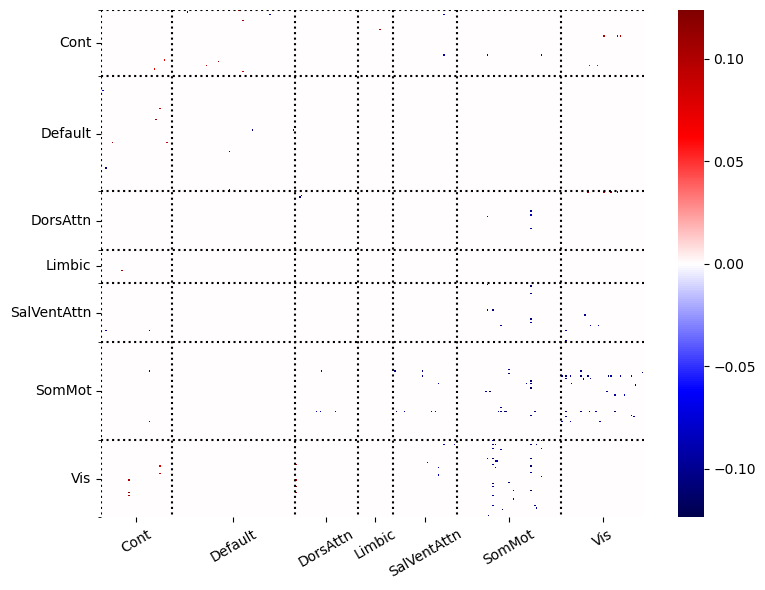

In [47]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(thresholded_t, atlas, True)
plt.show()

In [48]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]
ticks

Cont
Default
DorsAttn
Limbic
SalVentAttn
SomMot
Vis


[0, 52, 143, 189, 215, 262, 339, 400]

In [49]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Cont              (0, 52)
Default         (52, 143)
DorsAttn       (143, 189)
Limbic         (189, 215)
SalVentAttn    (215, 262)
SomMot         (262, 339)
Vis            (339, 400)
dtype: object

In [50]:
def block_count(matrix, network_to_idx):
    for network_a, network_b in itertools.combinations(network_to_idx.index, 2):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            yield network_a, network_b, n_positive_edges, n_negative_edges

In [51]:
count_vector = tuple(block_count(block_mat, network_to_idx))

posmat = reshape_pvalues([counts[2] for counts in count_vector])

negmat = reshape_pvalues([counts[3] for counts in count_vector])

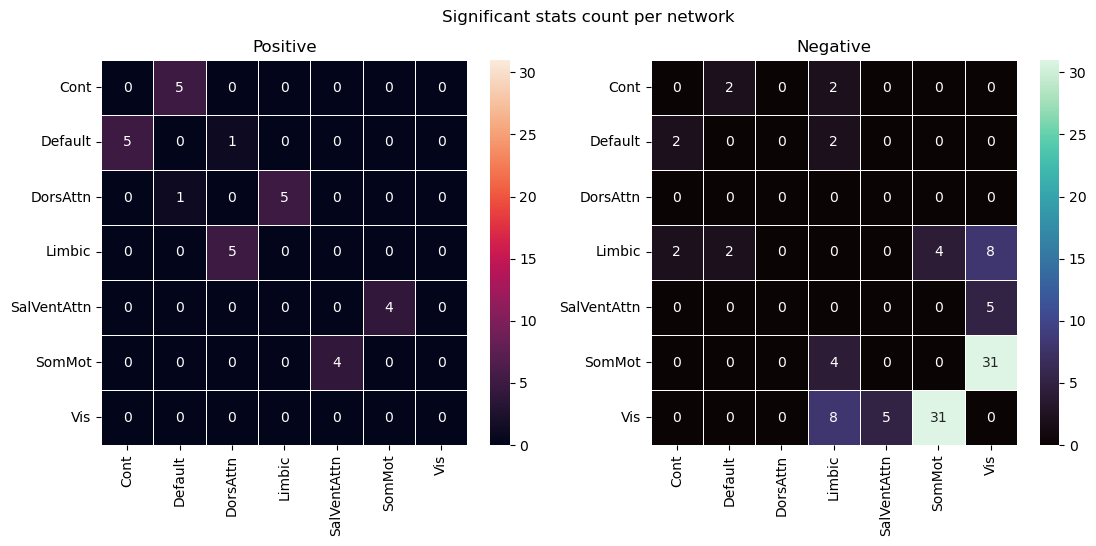

In [61]:
max_count = max(
    np.max(posmat),
    np.max(negmat),
)
heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(posmat, **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")
sns.heatmap(negmat, **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle("Significant stats count per network")
fig.show()

In [53]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="90%")
view.open_in_browser()